In [1]:
import numpy as np
import sympy as sp
from typing import Iterable, Callable
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from mpl_toolkits.mplot3d import Axes3D

In [2]:
State = tuple[float, float]
Path = Iterable[State]

In [3]:
class Surface3:
    def __init__(self,
        f: Callable[[float, float], float],
        xlim: tuple[float, float] = (-5.0, 5.0),
        ylim: tuple[float, float] = (-5.0, 5.0),
        resolution: int = 100
    ) -> None:
        self.f = f
        self.xlim = xlim
        self.ylim = ylim
        self.resolution = resolution

        self.X, self.Y = np.meshgrid(
            np.linspace(*xlim, resolution),
            np.linspace(*ylim, resolution)
        )
        self.Z = self.f(self.X, self.Y)

    def __call__(self, x: float, y: float) -> float:
        return self.f(x, y)

    def plot_3d(self, ax: Axes3D, path: Path = None) -> None:
        ax.plot_surface(self.X, self.Y, self.Z, cmap="viridis", alpha=0.8)

        if path is not None:
            path = np.array(path)
            ax.plot(path[:, 0], path[:, 1], [self.f(x, y) for x, y in path], label="Path", color="red", linewidth=0.5, zorder=4)

            start_x, start_y = path[0]
            ax.plot(start_x, start_y, self.f(start_x, start_y), label="Start state", color="blue", marker="D", markersize=5, zorder=4)

            best_x, best_y = path[-1]
            ax.plot(best_x, best_y, self.f(best_x, best_y), label="Best state", color="yellow", marker="*", markersize=10, zorder=4)

        ax.set_xlabel("x"); ax.set_ylabel("y")
        ax.set_zlabel("f(x, y)")

        ax.view_init(elev=60)
        ax.legend()

    def plot_2d(self, ax: Axes, path: Path = None) -> None:
        contour = ax.pcolormesh(self.X, self.Y, self.Z, cmap="viridis")
        plt.colorbar(contour)

        if path is not None:
            path = np.array(path)
            ax.plot(path[:, 0], path[:, 1], label="Path", color="red", linewidth=0.5)

            start_x, start_y = path[0]
            ax.plot(start_x, start_y, label="Start state", color="blue", marker="D", markersize=5)

            best_x, best_y = path[-1]
            ax.plot(best_x, best_y, label="Best state", color="yellow", marker="*", markersize=10)

        ax.set_xlabel("x")
        ax.set_ylabel("f(x)")
        ax.legend()

    def plot(self, path: Path = None) -> None:
        fig = plt.figure(figsize=(20, 8))

        ax1 = fig.add_subplot(121, projection="3d")
        self.plot_3d(ax1, path)

        ax2 = fig.add_subplot(122)
        self.plot_2d(ax2, path)

        plt.tight_layout()

In [4]:
class Schedule:
    def __init__(self, s: Callable[[int], float]) -> None:
        self.s = s

    def __call__(self, t: int) -> float:
        return self.s(t)

In [5]:
class SimulatedAnnealing:
    def __init__(self,
        surface: Surface3,
        schedule: Schedule,
        start_state: State,
        step_size: float = np.pi / 32,
        random_state: int = None
    ) -> None:
        self.surface = surface
        self.schedule = schedule
        self.step_size = step_size
        self.current_state = start_state

        self.best_state = start_state
        self.best_value = surface(*start_state)

        self.path = [start_state]

        if random_state is None:
            random_state = np.random.SeedSequence().entropy

        self.seed = random_state
        self.random = np.random.default_rng(random_state)

    def get_neighbors(self, state: State) -> list[State]:
        neighbors = [state]
        state_x, state_y = state

        for angle in np.linspace(0, 2 * np.pi, 8, endpoint=False):
            dx = self.step_size * np.cos(angle)
            dy = self.step_size * np.sin(angle)

            neighbor = state_x + dx, state_y + dy
            neighbors.append(neighbor)

        return neighbors

    def accept(self, candidate_value: float, current_value: float, t: float) -> bool:
        if candidate_value > current_value:
            return True
        else:
            delta = candidate_value - current_value
            prob = np.exp(-delta / t)

            return self.random.random() < prob

    def search(self, max_iters: int = 1000) -> tuple[State, float, Path]:
        for t in range(max_iters):
            new_t = self.schedule(t)

            neighbors = self.get_neighbors(self.current_state)

            candidate = self.random.choice(neighbors)
            candidate_value = self.surface(*candidate)

            current_value = self.surface(*self.current_state)

            if self.accept(candidate_value, current_value, new_t):
                self.current_state = candidate

                self.path.append(candidate)

                if candidate_value > self.best_value:
                    self.best_state = candidate
                    self.best_value = candidate_value

        return self.best_state, self.best_value, self.path

Seed: 117844577062006770338411923264921799524
Best state: [10.03764778 -2.97723845]
Best value: 4.536944720836846
Path: [(0, 0), array([0., 0.]), array([6.01147092e-18, 9.81747704e-02]), array([-0.09817477,  0.09817477]), array([-0.16759482,  0.02875472]), array([-0.09817477,  0.09817477]), array([-0.16759482,  0.02875472]), array([-0.26576959,  0.02875472]), array([-0.33518963, -0.04066532]), array([-0.40460968, -0.11008537]), array([-0.40460968, -0.0119106 ]), array([-0.40460968, -0.11008537]), array([-0.30643491, -0.11008537]), array([-0.30643491, -0.20826014]), array([-0.37585495, -0.27768018]), array([-0.37585495, -0.37585495]), array([-0.47402972, -0.37585495]), array([-0.54344977, -0.30643491]), array([-0.54344977, -0.30643491]), array([-0.47402972, -0.23701486]), array([-0.47402972, -0.33518963]), array([-0.40460968, -0.40460968]), array([-0.30643491, -0.40460968]), array([-0.37585495, -0.33518963]), array([-0.37585495, -0.23701486]), array([-0.37585495, -0.13884009]), array([-

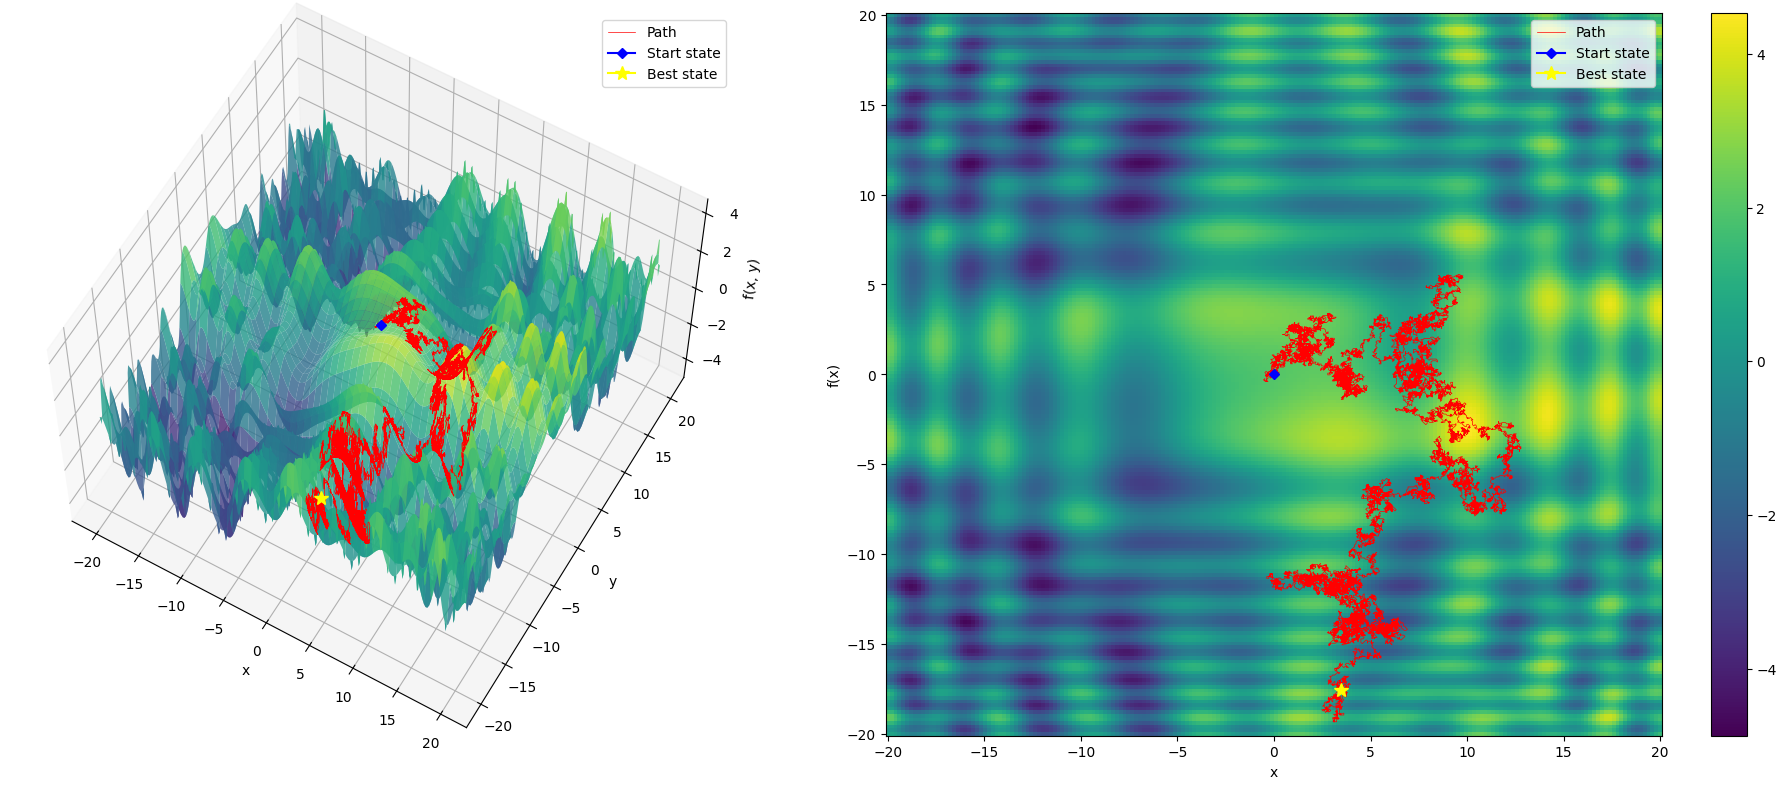

In [6]:
BEST_SEED = 117844577062006770338411923264921799524

x, y = sp.symbols("x y")
expr = sp.sin(x / 8) + sp.cos(y / 4) - sp.sin(x * y / 16) + sp.cos(x ** 2 / 16) + sp.sin(y ** 2 / 8)

f = sp.lambdify((x, y), expr)
task1 = Surface3(f, xlim=(-20.0, 20.0), ylim=(-20.0, 20.0), resolution=200)

schedule = Schedule(lambda t: max(1e-4, 1 / np.log(t + np.e)))
simulated_anneal = SimulatedAnnealing(task1, schedule, (0, 0), random_state=BEST_SEED)

best_state, best_value, path = simulated_anneal.search(max_iters=20000)

print("\n".join([
    f"Seed: {simulated_anneal.seed}",
    f"Best state: {best_state}",
    f"Best value: {best_value}",
    f"Path: {path}"
]))

task1.plot(path)